In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
# !pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2.0.0


In [17]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [20]:
from glob import glob

In [21]:
# resize all the images
IMAGE_SIZE = [224,224]

In [22]:
# training config
epochs = 5
batch_size = 32

In [23]:
train_path = '../fruits-360-small/Training/'
valid_path = '../fruits-360-small/Test/'

In [24]:
# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [25]:
# useful for getting number of classes
folders = glob(train_path + '/*')

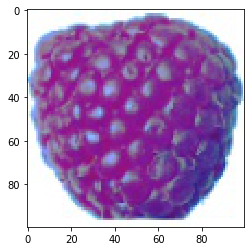

In [31]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [32]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = 'False')

In [33]:
for layer in vgg.layers:
    layer.trainable = False

In [35]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation = 'relu')(x)
prediction = Dense(len(folders), activation = 'softmax')(x)

# create model object
model = Model(inputs = vgg.input, outputs = prediction)

# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [36]:
# tell the model what cost and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [37]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function=preprocess_input
)

In [38]:
# test the generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)

Found 496 images belonging to 3 classes.
{'Banana': 0, 'Raspberry': 1, 'Strawberry': 2}


In [54]:
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min:  -106.779 max:  151.061


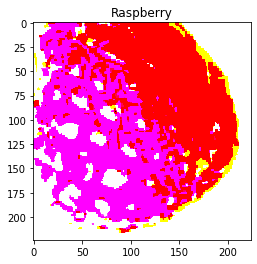

In [40]:
for x,y in test_gen:
    print("min: ", x[0].min(), "max: ", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [41]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 1472 images belonging to 3 classes.


In [42]:
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 496 images belonging to 3 classes.


In [43]:
# fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = epochs,
    steps_per_epoch = len(image_files) // batch_size,
    validation_steps = len(valid_image_files) // batch_size
)

Train for 46 steps, validate for 15 steps
Epoch 1/5
46/46 [==============================] - 192s 4s/step - loss: 1.0572 - accuracy: 0.9069 - val_loss: 1.0365 - val_accuracy: 0.9792
Epoch 2/5
46/46 [==============================] - 188s 4s/step - loss: 1.0117 - accuracy: 0.9952 - val_loss: 0.9924 - val_accuracy: 0.9979
Epoch 3/5
46/46 [==============================] - 184s 4s/step - loss: 0.9672 - accuracy: 0.9973 - val_loss: 0.9489 - val_accuracy: 0.9979
Epoch 4/5
46/46 [==============================] - 185s 4s/step - loss: 0.9248 - accuracy: 0.9993 - val_loss: 0.9090 - val_accuracy: 0.9979
Epoch 5/5
46/46 [==============================] - 185s 4s/step - loss: 0.8839 - accuracy: 1.0000 - val_loss: 0.8686 - val_accuracy: 0.9979


In [44]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x,y in gen.flow_from_directory(data_path, target_size = IMAGE_SIZE, 
                                       shuffle = False, batch_size = batch_size*2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis = 1)
        y = np.argmax(y, axis = 1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets,y))
        if len(targets)>= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

In [45]:
cm = get_confusion_matrix(train_path, len(image_files))

Generating confusion matrix 1472
Found 1472 images belonging to 3 classes.


In [46]:
print(cm)

[[490   0   0]
 [  0 489   1]
 [  1   0 491]]


In [47]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 496
Found 496 images belonging to 3 classes.
[[166   0   0]
 [  0 165   1]
 [  0   0 164]]


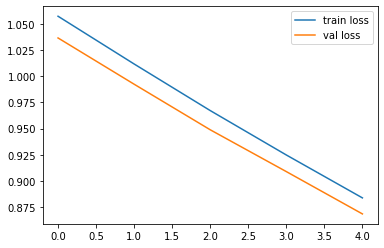

In [51]:
# plot some data
# loss
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

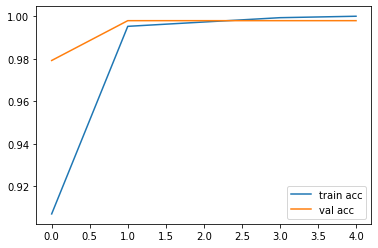

In [52]:
# accuracies
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

Confusion matrix, without normalization
[[490   0   0]
 [  0 489   1]
 [  1   0 491]]


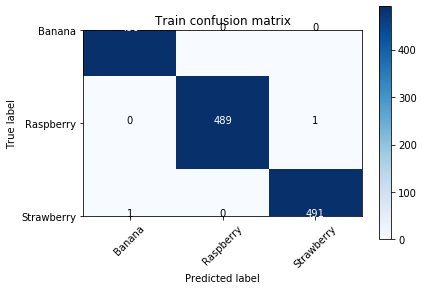

In [63]:
plot_confusion_matrix(cm, labels, title = 'Train confusion matrix')

Confusion matrix, without normalization
[[166   0   0]
 [  0 165   1]
 [  0   0 164]]


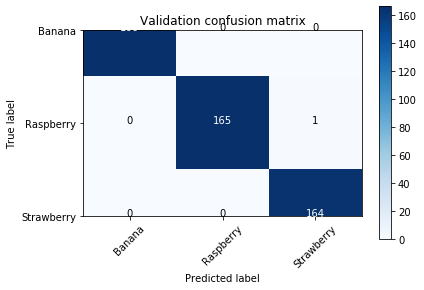

In [62]:
plot_confusion_matrix(valid_cm, labels, title = 'Validation confusion matrix')

In [57]:
labels

['Banana', 'Raspberry', 'Strawberry']